In [19]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
jtplot.reset()

In [3]:
class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

In [4]:
import numpy as np

class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff

In [5]:

class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        return 1./num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

In [74]:
class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))
        print(self.b)
        print(self.W)
    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()
    
        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)
    
        return softmaxOutput.loss(input, y)
    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()
    
        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)
    
        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)
    
    
    def train(self, X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()
    
        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))
    
            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW += reg_lambda * self.W[i-1]
                # Gradient descent parameter update
                self.b[i-1] += -epsilon * db
                self.W[i-1] += -epsilon * dW

            if print_loss and epoch % 1000 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))

In [15]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

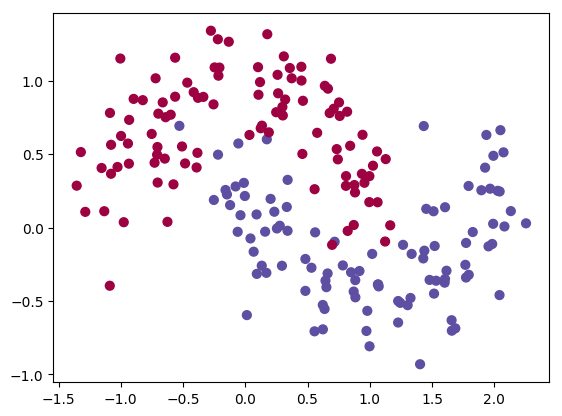

Loss after iteration 0: 0.700172
Loss after iteration 1000: 0.322747
Loss after iteration 2000: 0.192465
Loss after iteration 3000: 0.163409
Loss after iteration 4000: 0.161695
Loss after iteration 5000: 0.160960
Loss after iteration 6000: 0.160578
Loss after iteration 7000: 0.160359
Loss after iteration 8000: 0.160227
Loss after iteration 9000: 0.160145
Loss after iteration 10000: 0.160093
Loss after iteration 11000: 0.160059
Loss after iteration 12000: 0.160037
Loss after iteration 13000: 0.160022
Loss after iteration 14000: 0.160012
Loss after iteration 15000: 0.160005
Loss after iteration 16000: 0.160001
Loss after iteration 17000: 0.159997
Loss after iteration 18000: 0.159995
Loss after iteration 19000: 0.159994


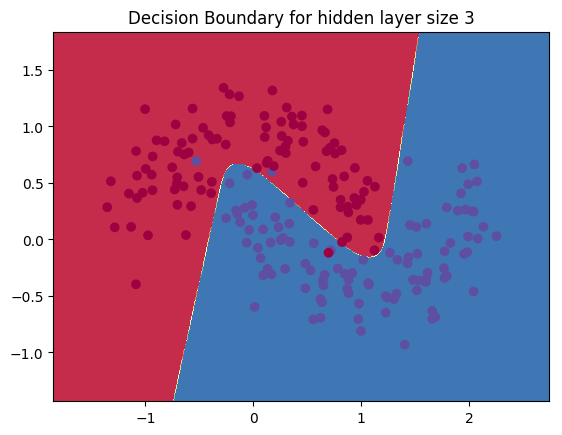

In [21]:

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

layers_dim = [2, 3, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

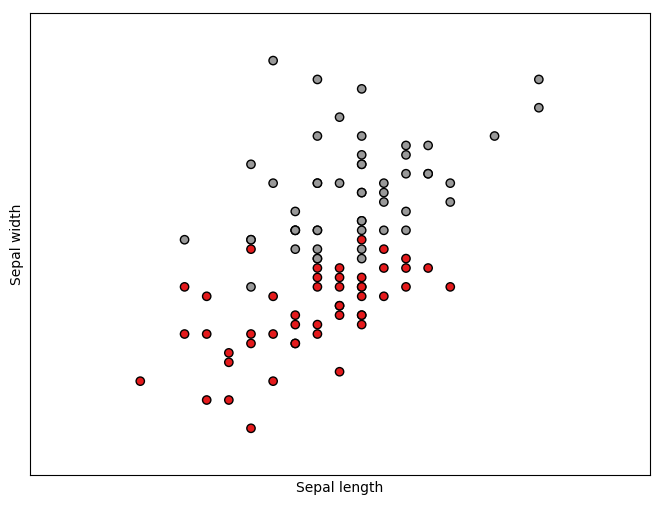

In [62]:
iris = sklearn.datasets.load_iris()
X = iris.data[50:,[1,2]]
y = iris.target[50:]-1
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

[array([[-1.21142064,  0.2901355 , -1.60419962]]), array([[ 0.25465471, -0.07388109]])]
[array([[-0.22378848,  0.75381669,  0.32799772],
       [-1.02478918,  0.44863369,  1.0160613 ]]), array([[ 0.58604408,  0.27115959],
       [ 0.24401503, -0.97470167],
       [-0.97849361,  0.07481749]])]
Loss after iteration 0: 0.693207
Loss after iteration 1000: 0.693159
Loss after iteration 2000: 0.693156
Loss after iteration 3000: 0.693148
Loss after iteration 4000: 0.693074
Loss after iteration 5000: 0.693140
Loss after iteration 6000: 0.602539
Loss after iteration 7000: 0.343150
Loss after iteration 8000: 0.310983
Loss after iteration 9000: 0.274328
Loss after iteration 10000: 0.315167
Loss after iteration 11000: 0.247641
Loss after iteration 12000: 0.238284
Loss after iteration 13000: 0.241354
Loss after iteration 14000: 0.241547
Loss after iteration 15000: 0.239342
Loss after iteration 16000: 0.246587
Loss after iteration 17000: 0.248949
Loss after iteration 18000: 0.243444
Loss after itera

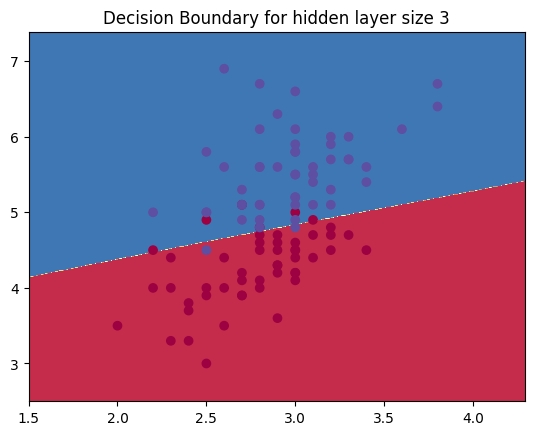

In [75]:
ayers_dim = [3, 5, 2]

model = Model(layers_dim)
model.train(X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

In [61]:
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
X.shape, y.shape
y

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1], dtype=int64)

In [48]:
iris = sklearn.datasets.load_iris()
X = iris.data[50:,[1,2]]
y = iris.target[50:]
X.shape, y.shape

((100, 2), (100,))

In [53]:
y-1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])